In [2]:
%matplotlib inline
# Beat tracking example
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# We'll need the os module for file path manipulation
import os
from os import walk

# And seaborn to make it look nice
import seaborn
seaborn.set(style='ticks')

# and IPython.display for audio output
import IPython.display


import matplotlib as mpl


from sklearn import datasets
from sklearn.cross_validation import StratifiedKFold
from sklearn.externals.six.moves import xrange
from sklearn import mixture

import sys
sys.path.append('src/')

import utils

In [64]:
reload(utils)

<module 'utils' from 'src/utils.pyc'>

In [65]:
#load DataFrame to merge features with eventually
DF_to_merge = pd.read_csv("/Users/mayarotmensch/Google_Drive/DSGA1003 - Project/Data/Final_Data/Master_4.26.15.csv")

In [66]:
#DF_to_merge.Filename
#DF_to_merge2 = pd.read_csv("/Users/mayarotmensch/Google Drive/DSGA1003 - Project/Data/Final_Data/Combined_Master.csv")

In [67]:
#print list(DF_to_merge.Filename.unique())

In [68]:
#valid_files_names_female
#q = 'male/1998_97_1868_kayatta_u_p_n_m.wav'
#'male/1998_97_1868_kayatta_u_p_n_m.wav' in valid_files_names_male
#valid_files_names_female

In [69]:
#set(b1).intersection(b2)
#set(valid_files_names_female).intersection(DF_to_merge.Filename)
#set(DF_to_merge.Filename).intersection(set(['1998_96_1570_young_u_p_f_m']))
#set(DF_to_merge.Filename).intersection(set(valid_files_names))


In [70]:
#get female files
path_female = "/Users/mayarotmensch/Google_Drive/DSGA1003 - Project/Data/original/female/"
y_series_female, sr_series_female,valid_files_names_female = utils.GetAudio(path_female)

#get male files
path_male = "/Users/mayarotmensch/Google_Drive/DSGA1003 - Project/Data/original/male/"
y_series_male, sr_series_male,valid_files_names_male = utils.GetAudio(path_male)


In [71]:
len(y_series_male)

1949

In [72]:
#parent file information
'''valid_files_names_female = ["female/"+file_name for file_name in valid_files_names_female]
valid_files_names_male = ["male/"+file_name for file_name in valid_files_names_male]'''

valid_files_names_female = [file_name[:-4] for file_name in valid_files_names_female]
valid_files_names_male = [file_name[:-4] for file_name in valid_files_names_male]

valid_files_names = valid_files_names_female+valid_files_names_male
#concatenate male+female information
sr = sr_series_male[0] # analysis has shows that all audio was samples at 22050.
y_series = y_series_female+y_series_male

In [73]:
# make sure we have all appropriate files loaded correctly
assert len(set(DF_to_merge.Filename).difference(set(valid_files_names))) == 0

In [74]:
hop_length = 512

In [75]:
## create dataframe into which we load all our new features
Acoustic_Data = pd.DataFrame(valid_files_names, columns = ["Audio"])
Acoustic_Data.set_index(Acoustic_Data.Audio, inplace = True)

# ** Onset Features **

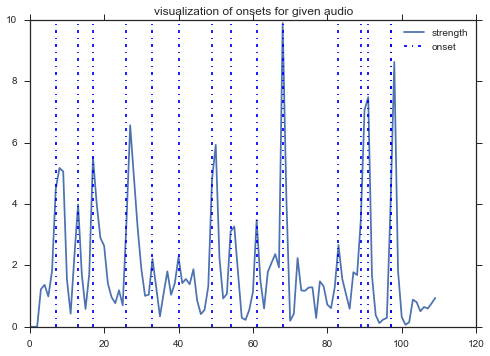

In [76]:
########## Visualization ########## 
detected_onset = librosa.onset.onset_detect(y=y_series[2],sr=sr,hop_length=hop_length)
onset_strengths = librosa.onset.onset_strength(y=y_series[2],sr=sr,hop_length=hop_length)

plt.plot(onset_strengths, label = "strength")
for d in detected_onset:
    plt.axvline(x=d, ymin=0, ymax=10,linestyle = '-.')

plt.axvline(x=detected_onset[-1], ymin=0, ymax=10,linestyle = '-.', label = "onset")
plt.title("visualization of onsets for given audio")
plt.legend()
plt.savefig("figures/onsets")


In [77]:
########## Features extraction ########## 
# onsets could also serve as a proxy for how many pauses the speaker takes.

def NumberOfOnsets(y_series, valid_files_names, DF, sr = sr):
    ''' change DF not inplace '''
    DF_copy = DF.copy()
    ## number of detected onsets
    for i,clip in enumerate(y_series):
        detected_onset = librosa.onset.onset_detect(y=clip,sr=sr,hop_length=hop_length)
        DF_copy.loc[valid_files_names[i],'onset_number'] = len(detected_onset)
    return DF_copy

In [78]:
Acoustic_Data = NumberOfOnsets(y_series= y_series, valid_files_names = valid_files_names, DF = Acoustic_Data, sr = sr)
Acoustic_Data.drop("Audio",1, inplace = True)

In [79]:
def OnsetStrengthChar(y_series, valid_files_names, DF, sr = sr):
    """ Charecteristics of onsets
    Args:
    
    Returns:
        max
        min
        mean
    """ 
    DF_copy = DF.copy()
    ## strength of detected onsets
    for i,clip in enumerate(y_series):        
        onset_strengths = librosa.onset.onset_strength(y=clip,sr=sr,hop_length=hop_length)
        DF_copy.loc[valid_files_names[i],'onset_strength_max'] = np.max(onset_strengths)
        DF_copy.loc[valid_files_names[i],'onset_strength_mean'] = np.mean(onset_strengths)
        DF_copy.loc[valid_files_names[i],'onset_strength_var'] = np.var(onset_strengths)
    return DF_copy
    

In [80]:
Acoustic_Data = OnsetStrengthChar(y_series=y_series, valid_files_names=valid_files_names, DF=Acoustic_Data)

# RMSE Feature

In [81]:
## Compute root-mean-square (RMS) energy for each frame.
## charecterizes "loudness"

def RSME(y_series, valid_files_names, DF):
    DF_copy = DF.copy()
    ## number of detected onsets
    for i,clip in enumerate(y_series):   
        DF_copy.loc[valid_files_names[i],'RMSE_max'] = np.mean(librosa.feature.rmse(y=clip))
        DF_copy.loc[valid_files_names[i],'RMSE_var'] = np.var(librosa.feature.rmse(y=clip))
    return DF_copy
    


In [82]:
Acoustic_Data = RSME(y_series=y_series, valid_files_names = valid_files_names, DF = Acoustic_Data)

In [84]:
Acoustic_Data.head(10)

,onset_number,onset_strength_max,onset_strength_mean,onset_strength_var,RMSE_max,RMSE_var
Audio,,,,,,
1998_96_1793_seitz_u_p_n_f,13,5.854709,1.757330,1.498846,1.458002,0.936990
1998_97_1287_blatt_s_acp_i_f,16,5.716841,1.846490,1.563648,1.554305,0.631686
1998_97_1418_millet_u_acp_i_f,14,9.896725,1.929223,3.510807,1.386466,1.130075
1998_97_1489_blatt_u_r_f_f,15,6.631968,1.868234,2.193339,1.459234,0.929881
1998_97_1489_gustin_u_p_n_f,17,6.299992,1.604102,1.073664,1.525704,0.737032
1998_97_1536_brinkman_u_acp_i_f,18,7.244723,1.938533,2.251241,1.421778,1.020848
1998_97_1754_millett_u_p_f_f,14,7.040922,1.871312,1.850027,1.409115,1.069015
1998_97_1754_wetts_u_r_n_f,14,5.707790,1.815444,1.562136,1.537557,0.670088
1998_97_1909_smith_u_p_n_f,17,5.897089,1.745992,1.489806,1.394035,1.103257


# Chromagram

In [85]:
# We'll use a CQT-based chromagram here.  An STFT-based implementation also exists in chroma_cqt()
# We'll use the harmonic component to avoid pollution from transients
#C = librosa.feature.chroma_cqt(y=y_series[3], sr=sr)

'''
# Make a new figure
plt.figure(figsize=(12,4))

# Display the chromagram: the energy in each chromatic pitch class as a function of time
# To make sure that the colors span the full range of chroma values, set vmin and vmax
librosa.display.specshow(C, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)

plt.title('Chromagram')
plt.colorbar()

plt.tight_layout()'''

"\n# Make a new figure\nplt.figure(figsize=(12,4))\n\n# Display the chromagram: the energy in each chromatic pitch class as a function of time\n# To make sure that the colors span the full range of chroma values, set vmin and vmax\nlibrosa.display.specshow(C, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)\n\nplt.title('Chromagram')\nplt.colorbar()\n\nplt.tight_layout()"

In [86]:
def PitchMetrics(y_series, valid_files_names, DF, sr = sr):
    DF_copy = DF.copy()
    for i,clip in enumerate(y_series):   
        C = librosa.feature.chroma_cqt(y=clip, sr=sr)
        for j in range(C.shape[0]):
            DF_copy.loc[valid_files_names[i],'Pitch_%s' %j] = np.mean(C[j,:])
            #print mean
    return DF_copy

    

In [87]:
NEW = PitchMetrics(y_series=y_series, valid_files_names = valid_files_names, DF = Acoustic_Data)

In [89]:
NEW.head()

,onset_number,onset_strength_max,onset_strength_mean,onset_strength_var,RMSE_max,RMSE_var,Pitch_0,Pitch_1,Pitch_2,Pitch_3,Pitch_4,Pitch_5,Pitch_6,Pitch_7,Pitch_8,Pitch_9,Pitch_10,Pitch_11
Audio,,,,,,,,,,,,,,,,,,
1998_96_1793_seitz_u_p_n_f,13,5.854709,1.757330,1.498846,1.458002,0.936990,0.574348,0.568631,0.515068,0.591022,0.533305,0.459878,0.495243,0.485591,0.421840,0.396215,0.411003,0.365309
1998_97_1287_blatt_s_acp_i_f,16,5.716841,1.846490,1.563648,1.554305,0.631686,0.474540,0.504153,0.473202,0.492053,0.388192,0.378821,0.492952,0.632042,0.673775,0.499150,0.429502,0.363781
1998_97_1418_millet_u_acp_i_f,14,9.896725,1.929223,3.510807,1.386466,1.130075,0.636672,0.644117,0.647330,0.514262,0.456698,0.396259,0.381926,0.368830,0.374476,0.501599,0.383126,0.391440
1998_97_1489_blatt_u_r_f_f,15,6.631968,1.868234,2.193339,1.459234,0.929881,0.577103,0.540580,0.423197,0.428155,0.431954,0.516822,0.523793,0.593789,0.557094,0.584877,0.529765,0.437058
1998_97_1489_gustin_u_p_n_f,17,6.299992,1.604102,1.073664,1.525704,0.737032,0.475306,0.512333,0.448028,0.374256,0.389251,0.398331,0.548889,0.572904,0.427061,0.493102,0.459444,0.383952


In [47]:
Added_DF = pd.merge(DF_to_merge, NEW, how='left', left_on='Filename', right_on=None,
          left_index=False, right_index=True, copy=True)

In [63]:
Added_DF=Added_DF.drop(["Unnamed: 0"],1)
Added_DF.to_csv("Master_27_4.csv")

In [15]:
DF =pd.read_csv("Master_27_4.csv")


In [16]:
DF.head()

,Unnamed: 0,WorkerId,Filename,AssignmentId,Aggressive,Attractive,Confident,Intelligent,Masculine,Quality,...,Pitch_2,Pitch_3,Pitch_4,Pitch_5,Pitch_6,Pitch_7,Pitch_8,Pitch_9,Pitch_10,Pitch_11
0,0,A1EB857G7CK9K9,1998_96_1570_brown_u_r_n_m,3B3WTRP3DB2DXOPUGOJUSOPRSHS92C,2,3,4,5,3,5,...,0.644422,0.655973,0.604729,0.651543,0.580218,0.494154,0.488906,0.55512,0.503023,0.447732
1,1,A380PU6ZH8UEBV,1998_96_1570_brown_u_r_n_m,3P59JYT76LKWH3Y8EUOBJOQ3N4ET2C,4,4,5,4,7,7,...,0.644422,0.655973,0.604729,0.651543,0.580218,0.494154,0.488906,0.55512,0.503023,0.447732
2,2,A37WQ2HYE1M86A,1998_96_1570_brown_u_r_n_m,3LWJHTCVCCM3QHISLL9NY295BPPQFV,5,3,6,2,6,5,...,0.644422,0.655973,0.604729,0.651543,0.580218,0.494154,0.488906,0.55512,0.503023,0.447732
3,3,A1DCA3FSX06H6F,1998_96_1570_brown_u_r_n_m,3E4GGUZ1T8RXEK8LKLAJIX374RZK29,4,3,4,5,6,7,...,0.644422,0.655973,0.604729,0.651543,0.580218,0.494154,0.488906,0.55512,0.503023,0.447732
4,4,A2XCEA0G25DT6W,1998_96_1570_brown_u_r_n_m,3GNA64GUZE4BOKP3F9WECQISN1FQ5T,5,5,5,5,6,6,...,0.644422,0.655973,0.604729,0.651543,0.580218,0.494154,0.488906,0.55512,0.503023,0.447732


In [17]:
from sklearn import datasets 
from sklearn.mixture import GMM
iris = datasets.load_iris()

In [18]:
from sklearn import datasets
from sklearn.cross_validation import StratifiedKFold

In [154]:
skf = StratifiedKFold(iris.target, n_folds=4)
# Only take the first fold.
train_index, test_index = next(iter(skf))


X_train = iris.data[train_index]
y_train = iris.target[train_index]

In [155]:
iris.data.shape

(150, 4)

In [161]:
X_train.shape
n_classes = len(np.unique(y_train))

In [162]:
# Try GMMs using different types of covariances.
classifiers = dict((covar_type, GMM(n_components=n_classes,
                    covariance_type=covar_type, init_params='wc', n_iter=20))
                   for covar_type in ['spherical', 'diag', 'tied', 'full'])



# MFCC

In [14]:
mfccs = librosa.feature.mfcc(y=y_series[0], sr=sr,n_mfcc=39)

In [15]:
mfccs = librosa.feature.mfcc(y=y_series[0], sr=sr,n_mfcc=39)
mfcc_matrix = mfccs.T

from sklearn.cross_validation import KFold

In [16]:
mfcc_train = mfcc_matrix[:80,:]
mfcc_test = mfcc_matrix[80:,:]

In [95]:
GMM_Data = pd.DataFrame(valid_files_names, columns = ["Audio"])
GMM_Data.set_index(GMM_Data.Audio, inplace = True)
To_Add =pd.read_csv("Master_27_4.csv")
GMM_Data.head()

,Audio
Audio,
1998_96_1793_seitz_u_p_n_f,1998_96_1793_seitz_u_p_n_f
1998_97_1287_blatt_s_acp_i_f,1998_97_1287_blatt_s_acp_i_f
1998_97_1418_millet_u_acp_i_f,1998_97_1418_millet_u_acp_i_f
1998_97_1489_blatt_u_r_f_f,1998_97_1489_blatt_u_r_f_f
1998_97_1489_gustin_u_p_n_f,1998_97_1489_gustin_u_p_n_f


### Fitting a single Gaussian

In [96]:
def SignleGausModel(y_series,valid_files_names, DF):
    """ 
    Note that score is the log probability. so the closer to 0 is better
    Args:
        X_train
        X_test
        n_comp - int. indicates how many gaussians we want in our mixture.
    """
    DF_copy = DF.copy()
    
    for i,clip in enumerate(y_series): 
       
        #get mfcc's for each audio clip
        mfccs = librosa.feature.mfcc(y=clip, sr=sr,n_mfcc=39)
        mfcc_matrix = mfccs.T
    
        # create the classifier 
        clf = mixture.GMM(n_components=1,covariance_type='diag')
        # train 
        clf.fit(mfcc_matrix) 
    
        # get params
        means = clf.means_[0]
        variances = clf.covars_[0]

        #load new features into DF
        for var, mean in enumerate(means):
            DF_copy.loc[valid_files_names[i],'Gaus_mean_%d' %var] = mean
            DF_copy.loc[valid_files_names[i],'Gaus_var_%d' %var] = variances[var]
            
    return DF_copy

#retrun the mean log probability of the new points being drawn fromt the models distribution
#return np.mean(clf.score(X_test))


In [100]:
GMM_Data.head()

,Audio,Gaus_mean_0,Gaus_var_0,Gaus_mean_1,Gaus_var_1,Gaus_mean_2,Gaus_var_2,Gaus_mean_3,Gaus_var_3,Gaus_mean_4,...,Gaus_mean_34,Gaus_var_34,Gaus_mean_35,Gaus_var_35,Gaus_mean_36,Gaus_var_36,Gaus_mean_37,Gaus_var_37,Gaus_mean_38,Gaus_var_38
Audio,,,,,,,,,,,,,,,,,,,,,
1998_96_1793_seitz_u_p_n_f,1998_96_1793_seitz_u_p_n_f,-209.782037,2080.348993,85.481380,1266.777263,-29.410935,516.289144,44.295229,426.833538,-35.037433,...,-4.658091,81.186393,7.604983,94.326138,-4.155513,69.094189,5.969019,63.439882,-3.543792,70.273327
1998_97_1287_blatt_s_acp_i_f,1998_97_1287_blatt_s_acp_i_f,-211.864782,1220.157024,74.470579,1686.778205,-24.811282,559.547444,63.165263,732.640208,-32.789595,...,2.304805,105.928563,10.792162,69.539790,0.724337,70.841633,4.781015,53.247528,-1.170447,38.844208
1998_97_1418_millet_u_acp_i_f,1998_97_1418_millet_u_acp_i_f,-221.036213,4219.203045,72.528923,1035.068431,-23.613253,749.184123,56.713898,486.443142,-32.128203,...,-4.047863,49.342224,2.996525,42.140119,-5.068607,31.459395,1.341898,30.152752,-1.426135,36.728699
1998_97_1489_blatt_u_r_f_f,1998_97_1489_blatt_u_r_f_f,-217.749038,2600.413601,73.711299,2159.750594,-28.131418,858.271361,61.566130,1160.056400,-26.244511,...,-0.602846,97.195039,10.204692,71.259242,0.498068,99.921671,7.799091,42.854255,1.231669,26.651935
1998_97_1489_gustin_u_p_n_f,1998_97_1489_gustin_u_p_n_f,-214.735789,1471.766449,80.214611,981.829555,-15.176274,329.921624,62.188578,285.177114,-35.288580,...,-0.397769,129.430862,12.680760,145.773862,5.216680,188.481126,9.960721,89.259228,0.492482,64.886136


In [97]:
GMM_Data = SignleGausModel(y_series=y_series,valid_files_names=valid_files_names, DF=GMM_Data)

In [101]:
Added_GMM_DF = pd.merge(To_Add, GMM_Data, how='left', left_on='Filename', right_on='Audio',
         left_index=False, right_index=True, copy=True)

In [104]:
Added_GMM_DF.head(20)

,Unnamed: 0,WorkerId,Filename,AssignmentId,Aggressive,Attractive,Confident,Intelligent,Masculine,Quality,...,Gaus_mean_34,Gaus_var_34,Gaus_mean_35,Gaus_var_35,Gaus_mean_36,Gaus_var_36,Gaus_mean_37,Gaus_var_37,Gaus_mean_38,Gaus_var_38
0,0,A1EB857G7CK9K9,1998_96_1570_brown_u_r_n_m,3B3WTRP3DB2DXOPUGOJUSOPRSHS92C,2,3,4,5,3,5,...,-7.088809,18.355194,3.978956,20.580763,-5.811444,18.451122,1.524474,15.380362,-4.498156,15.07049
1,1,A380PU6ZH8UEBV,1998_96_1570_brown_u_r_n_m,3P59JYT76LKWH3Y8EUOBJOQ3N4ET2C,4,4,5,4,7,7,...,-7.088809,18.355194,3.978956,20.580763,-5.811444,18.451122,1.524474,15.380362,-4.498156,15.07049
2,2,A37WQ2HYE1M86A,1998_96_1570_brown_u_r_n_m,3LWJHTCVCCM3QHISLL9NY295BPPQFV,5,3,6,2,6,5,...,-7.088809,18.355194,3.978956,20.580763,-5.811444,18.451122,1.524474,15.380362,-4.498156,15.07049
3,3,A1DCA3FSX06H6F,1998_96_1570_brown_u_r_n_m,3E4GGUZ1T8RXEK8LKLAJIX374RZK29,4,3,4,5,6,7,...,-7.088809,18.355194,3.978956,20.580763,-5.811444,18.451122,1.524474,15.380362,-4.498156,15.07049
4,4,A2XCEA0G25DT6W,1998_96_1570_brown_u_r_n_m,3GNA64GUZE4BOKP3F9WECQISN1FQ5T,5,5,5,5,6,6,...,-7.088809,18.355194,3.978956,20.580763,-5.811444,18.451122,1.524474,15.380362,-4.498156,15.07049
5,5,A25FV5NFFE0PAI,1998_96_1570_brown_u_r_n_m,3DYGAII7PL8FHU7MZO5SAWN9DVFQP1,2,4,3,6,6,3,...,-7.088809,18.355194,3.978956,20.580763,-5.811444,18.451122,1.524474,15.380362,-4.498156,15.07049
6,6,A11N8D0L560PVJ,1998_96_1570_brown_u_r_n_m,3EQHHY4HQSSKBVVPCDR2ICEQG9CG5J,4,5,5,5,6,6,...,-7.088809,18.355194,3.978956,20.580763,-5.811444,18.451122,1.524474,15.380362,-4.498156,15.07049
7,7,A3EPBFTXWBRHVY,1998_96_1570_brown_u_r_n_m,3Z2R0DQ0JHEUSKGBOZZGK2Q2JE02E7,3,3,3,3,4,6,...,-7.088809,18.355194,3.978956,20.580763,-5.811444,18.451122,1.524474,15.380362,-4.498156,15.07049
8,8,A2SMAZGQOV2IAU,1998_96_1570_brown_u_r_n_m,36U2A8VAG1ZNF51SD6HER14CIQGKYF,7,5,6,6,7,7,...,-7.088809,18.355194,3.978956,20.580763,-5.811444,18.451122,1.524474,15.380362,-4.498156,15.07049
9,9,A2Y0SIZH81B265,1998_96_1570_brown_u_r_n_m,34V1S5K3GS11FP8V3QVXI1638RM69S,6,4,6,6,7,6,...,-7.088809,18.355194,3.978956,20.580763,-5.811444,18.451122,1.524474,15.380362,-4.498156,15.07049


In [107]:
#Added_GMM_DF=Added_GMM_DF.drop(["Unnamed: 0", "Audio"],1)

Added_GMM_DF.to_csv("Master_30_4.csv")

## Autocorrelation of Onset

In [108]:
onset_strengths = librosa.onset.onset_strength(y=y_series[2],sr=sr,hop_length=hop_length)

In [16]:
for i in DF.columns:
    print i

WorkerId
Filename
AssignmentId
Aggressive
Attractive
Confident
Intelligent
Masculine
Quality
Trust
Win
AssignmentDurationInSeconds
WorkTimeInSeconds
Answer.ProfileEducation
Answer.ProfileIncome
Age
Age_Log
Female
Male
African American
American Indian or Native American
Asian
Hispanic or Latino/Latina
Native Hawaiian or Pacific Islander
White
Alabama
Alaska
Arizona
Arkansas
California
Colorado
Connecticut
Delaware
District of Columbia
Florida
Georgia
Hawaii
Idaho
Illinois
Indiana
Iowa
Kansas
Kentucky
Louisiana
Maine
Maryland
Massachusetts
Michigan
Minnesota
Mississippi
Missouri
Montana
Nebraska
Nevada
New Hampshire
New Jersey
New Mexico
New York
North Carolina
Ohio
Oklahoma
Oregon
Pennsylvania
Rhode Island
South Carolina
South Dakota
Tennessee
Texas
Utah
Vermont
Virginia
Washington
West Virginia
Wisconsin
Wyoming
F1.AH0
F2.AH0
F3.AH0
F1.AH1
F2.AH1
F3.AH1
F1.AO1
F2.AO1
F3.AO1
F1.ER0
F2.ER0
F3.ER0
F1.EY1
F2.EY1
F3.EY1
F1.IH1
F2.IH1
F3.IH1
F1.IY1
F2.IY1
F3.IY1
durPerPhone
Phonecount
PhoneP

In [27]:
DF = pd.read_csv("Data/Master_30_4.csv")
DF = DF.drop(["Answer.ProfileYear","Unnamed: 0","Age_Log"],1)

In [28]:
DF["Age_squared"] = (DF.Age)**2

In [29]:
DF.to_csv("Data/Master_9_5.csv")

AttributeError: 'DataFrame' object has no attribute 'Age_Log'